In [ ]:
from google.colab import files

# Choose the kaggle.json file that you downloaded
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Move the uploaded file to the required folder
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d shubhamgoel27/dermnet

100% 1.72G/1.72G [00:59<00:00, 27.2MB/s]
100% 1.72G/1.72G [00:59<00:00, 30.8MB/s]


In [ ]:
# Unzip the dataset
!unzip -q dermnet.zip -d dermnet_dataset

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, AveragePooling2D
from keras.applications import ResNet50V2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

In [ ]:
def plotImages(images_arr, labels, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        class_index = np.argmax(label)
        ax.set_title(class_names[class_index])  # Display the actual class name
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Setting up data directories
train_dir = "/content/dermnet_dataset/train"
test_dir = "/content/dermnet_dataset/test"
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"

In [ ]:
# Constants
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
num_classes = 23

In [ ]:
# Creating ImageDataGenerators
train_image_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255
)

test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


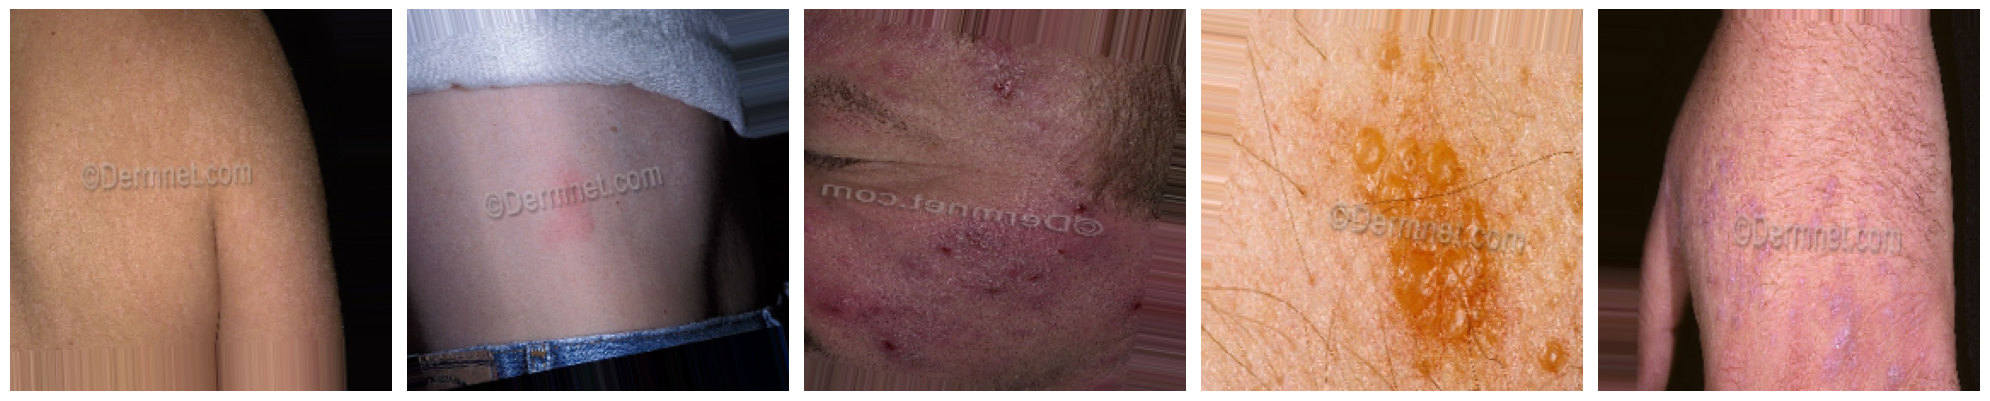

In [ ]:
class_names = train_data_gen.classes
imgs, class_names = next(train_data_gen)
print(class_names[:5])
plotImages(imgs)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


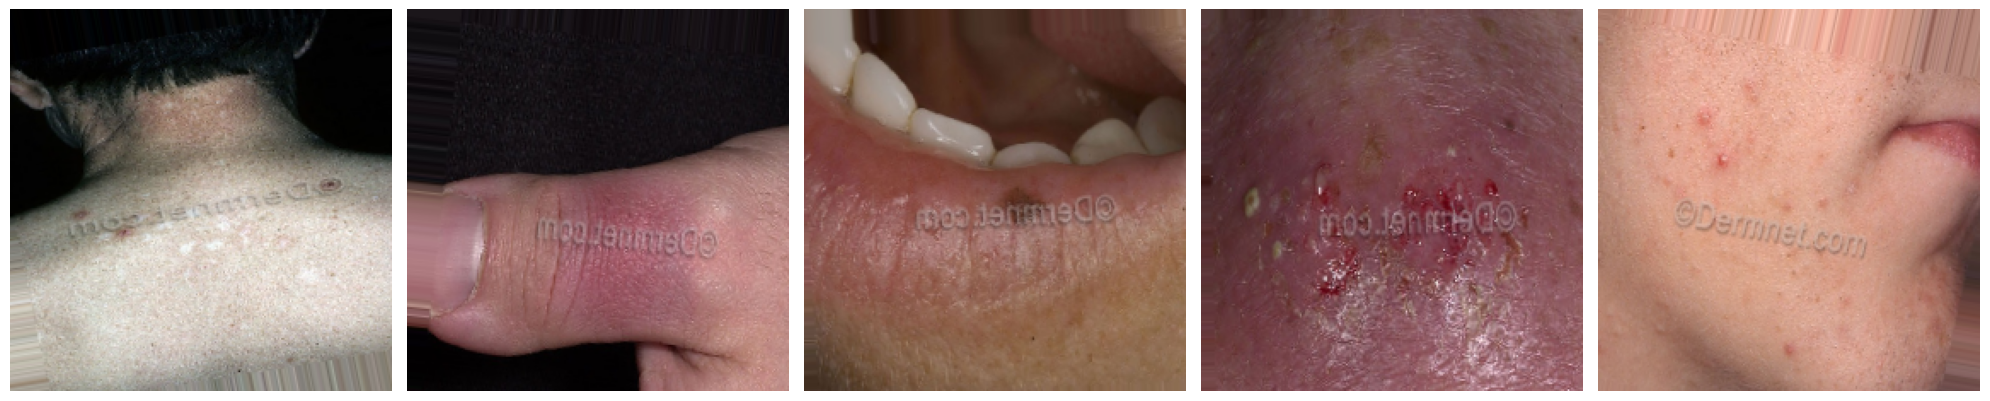

In [ ]:
class_names = train_data_gen.classes
imgs, class_names = next(train_data_gen)
print(class_names[:5])
plotImages(imgs)

In [ ]:
# Load pre-trained ResNet50 model
base_model = ResNet50V2(
    include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights="imagenet"
)
base_model.trainable = False

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
# Build the model
def create_model():
    model = Sequential()
    model.add(base_model)
    model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.000035),
        metrics=["accuracy"],
    )
    return model

In [ ]:
# Callbacks
callback = EarlyStopping(
    monitor="val_loss", patience=6, min_delta=0.03, verbose=2
)
reduceLR = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.01,
    patience=2,
    min_lr=0.000035,
    min_delta=0.01,
    verbose=2,
)
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=2,
)

In [ ]:
# Create and compile the model
model = create_model()

In [ ]:
# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=10,
    validation_data=test_data_gen,
    validation_steps=test_data_gen.samples // batch_size,
    callbacks=[callback, reduceLR, checkpoint],
    verbose=1,
)

Epoch 1/10
486/486 [==============================] - ETA: 0s - loss: 2.1676 - accuracy: 0.3608
Epoch 1: val_loss improved from inf to 2.28425, saving model to training_1/cp-0001.ckpt
486/486 [==============================] - 269s 553ms/step - loss: 2.1676 - accuracy: 0.3608 - val_loss: 2.2843 - val_accuracy: 0.3470 - lr: 3.5000e-05
Epoch 2/10
486/486 [==============================] - ETA: 0s - loss: 2.0494 - accuracy: 0.3913
Epoch 2: val_loss improved from 2.28425 to 2.21928, saving model to training_1/cp-0002.ckpt
486/486 [==============================] - 266s 548ms/step - loss: 2.0494 - accuracy: 0.3913 - val_loss: 2.2193 - val_accuracy: 0.3605 - lr: 3.5000e-05
Epoch 3/10
486/486 [==============================] - ETA: 0s - loss: 1.9357 - accuracy: 0.4259
Epoch 3: val_loss did not improve from 2.21928
486/486 [==============================] - 263s 540ms/step - loss: 1.9357 - accuracy: 0.4259 - val_loss: 2.2237 - val_accuracy: 0.3607 - lr: 3.5000e-05
Epoch 4/10
486/486 [=========

In [ ]:
# Evaluate the model
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

# Calculate steps_per_epoch for the test data
test_steps = test_data_gen.samples // batch_size

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data_gen, steps=test_steps, verbose=1)
print("Test accuracy:", test_acc)


Found 4002 images belonging to 23 classes.
125/125 [==============================] - 21s 170ms/step - loss: 2.0803 - accuracy: 0.4223
Test accuracy: 0.42225000262260437


In [ ]:
# Save the model
model.save("../Models/test1/MedicalClassification_ResNet50V2", overwrite=True)
model.save_weights(
    "../Models/test1/MedicalClassification_ResNet50V2.hdf5", overwrite=True, save_format="h5"
)

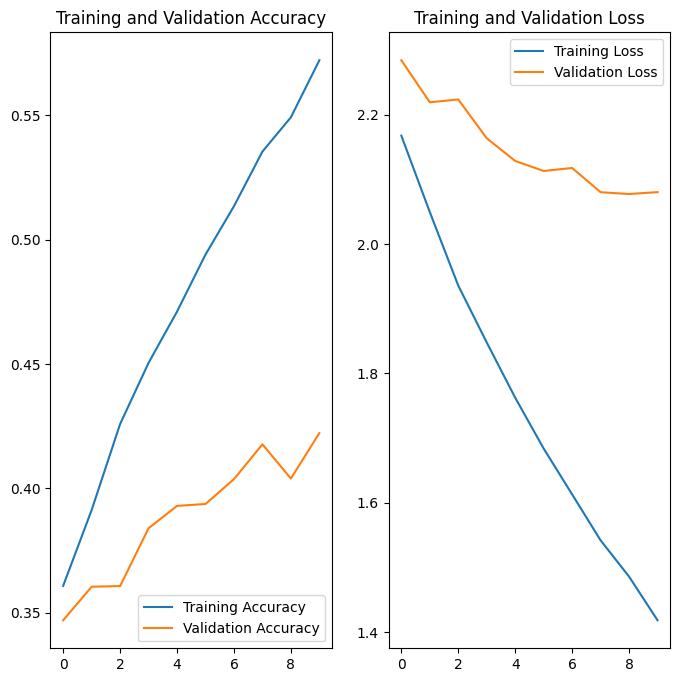

In [ ]:
# Plot training history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# Prediction
predictions = model.predict(test_data_gen)

126/126 [==============================] - 21s 164ms/step
